In [1]:
import numpy as np
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import sys
import os
import threading
from threading import Thread, Lock
import h5py
import re
import datetime

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean, rotate, AffineTransform, warp
from skimage.io import imread, imsave
import tifffile as tiff
import matplotlib.pyplot as plt

import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import random
import PIL.Image
import PIL.ImageEnhance
import PIL.ImageOps
import copy

from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import random_rotation, random_shift, random_shear, random_zoom, random_channel_shift
from tensorflow.keras.utils import array_to_img, img_to_array, load_img, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.optimizers.experimental import SGD

import glob, fnmatch

from models import inceptionV3 as inceptionV3

from helpers import *

2023-08-02 17:12:33.524103: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-02 17:12:44.884877: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sathlerar/data/conda/lib:/usr/local/CUDA/11.3.0/bin:/usr/local/CUDA/11.3.0/targets/x86_64-linux/lib:/usr/local/cuDNN/8.2.1/CUDA-11.3/lib64:/usr/bin
2023-08-02 17:12:44.885006: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or dire

In [2]:
from matplotlib import pyplot as plt

In [3]:
def preprocessing(nb_trainings, parameters):
    for i in range(nb_trainings):
        if type(parameters[0]) == np.ndarray:
            if parameters[0][i].selected==None:
                sys.exit("Preprocessing #"+str(i+1)+": You need to select an input directory for preprocessing")
            if parameters[1][i].selected==None:
                sys.exit("Preprocessing #"+str(i+1)+": You need to select an output directory for preprocessed data")
            
            preprocess(parameters[0][i].selected, parameters[1][i].selected, 
                       parameters[2][i].children[1].value, parameters[3][i].children[1].value, 
                       parameters[4][i].children[1].value, parameters[5][i].children[1].value)
        else:
            if not os.path.isdir(parameters[0]):
                sys.exit("Preprocessing #"+str(i+1)+": You need to select an input directory for preprocessing")
            if not os.path.isdir(parameters[1]):
                sys.exit("Preprocessing #"+str(i+1)+": You need to select an input directory for preprocessed data")
            
            preprocess(parameters[0], parameters[1], parameters[2],
                       parameters[3], parameters[4], parameters[5])

In [4]:
J_ROOT = os.readlink('/proc/%s/cwd' % os.environ['JPY_PARENT_PID'])
input_dir = os.path.join(J_ROOT, 'pecot', '23-07-04_16x16_crop_and_pad', '23-07-04_cNp_annotation', 'nucleiSegmentation')
crop_dir_base = os.path.join(J_ROOT, 'pecot', '23-08-02_32x32_crop_and_pad', '23-08-02_cNp_annotation_cNp')
crop_dir = os.path.join(J_ROOT, 'pecot', '23-08-02_32x32_crop_and_pad', '23-08-02_cNp_annotation_cNp', 'nucleiSegmentation')
output_dir = os.path.join(J_ROOT, 'pecot', '23-08-02_32x32_crop_and_pad', '23-08-02_cNp_annotation_npz', 'nucleiSegmentation')
nb_classes = 3
window_size_x = 32
window_size_y = 32
normalization = 'nuclei segmentation'
#parameters = [input_dir, output_dir, nb_classes, window_size_x, window_size_y, normalization]

In [5]:
# search images to find smallest dimension
smallest = get_largest_dim(getfiles(input_dir))
image_size_x, image_size_y = smallest, smallest
print(f"The largest image dimension is {smallest}. All images will be randomly cropped and resized to {smallest}x{smallest}.\n" \
      + f"Outputs will be resized to the same scale")

The largest image dimension is 1076. All images will be randomly cropped and resized to 1076x1076.
Outputs will be resized to the same scale


In [6]:
%%capture
#generate crops
image_directories = [i for i in os.listdir(input_dir)]

NUM_CROPS = 18
BATCH_SIZE = 1

crop_list = []
for directory in image_directories:
    #crops will be shared for all features of a single image
    boxes = tf.random.uniform(shape = (NUM_CROPS, 4))
    box_indices = tf.random.uniform(shape = (NUM_CROPS, ), minval = 0, maxval = BATCH_SIZE, dtype = tf.int32)
    
    for image in os.listdir(os.path.join(input_dir, directory)):
        if image == '.ipynb_checkpoints' or image == "Thumbs.db" or image == ".DS_Store":
            continue

        basedir = os.path.join(crop_dir, f"{directory}_base")
        os.makedirs(os.path.join(crop_dir, f"{directory}_base"), exist_ok=True)
        for i in range(NUM_CROPS):
            os.makedirs(os.path.join(crop_dir, f"{directory}_c{i}"), exist_ok=True)

        im = get_image(os.path.join(input_dir, directory, image))
        value = get_closest_val(np.mean(im), (np.iinfo(im.dtype).min, np.iinfo(im.dtype).max))
        
        im = np.float32(im)
        padded = np.full((image_size_x, image_size_y), value)
        padded[:im.shape[0],:im.shape[1]] = im
        padded = np.float32(padded)
        crop_list.append(padded)
        imsave(os.path.join(basedir, image), padded)
        
        im_crops = tf.image.crop_and_resize(im[None,:,:,None], boxes, box_indices, (image_size_x, image_size_y))

        for jdx, crop in enumerate(im_crops):
            savepath = os.path.join(crop_dir, f"{directory}_c{jdx}", image)
            crop_list.append(crop[:,:,0])
            imsave(savepath, crop[:,:,0].numpy())

2023-08-02 17:13:08.133498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79116 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c7:00.0, compute capability: 8.0


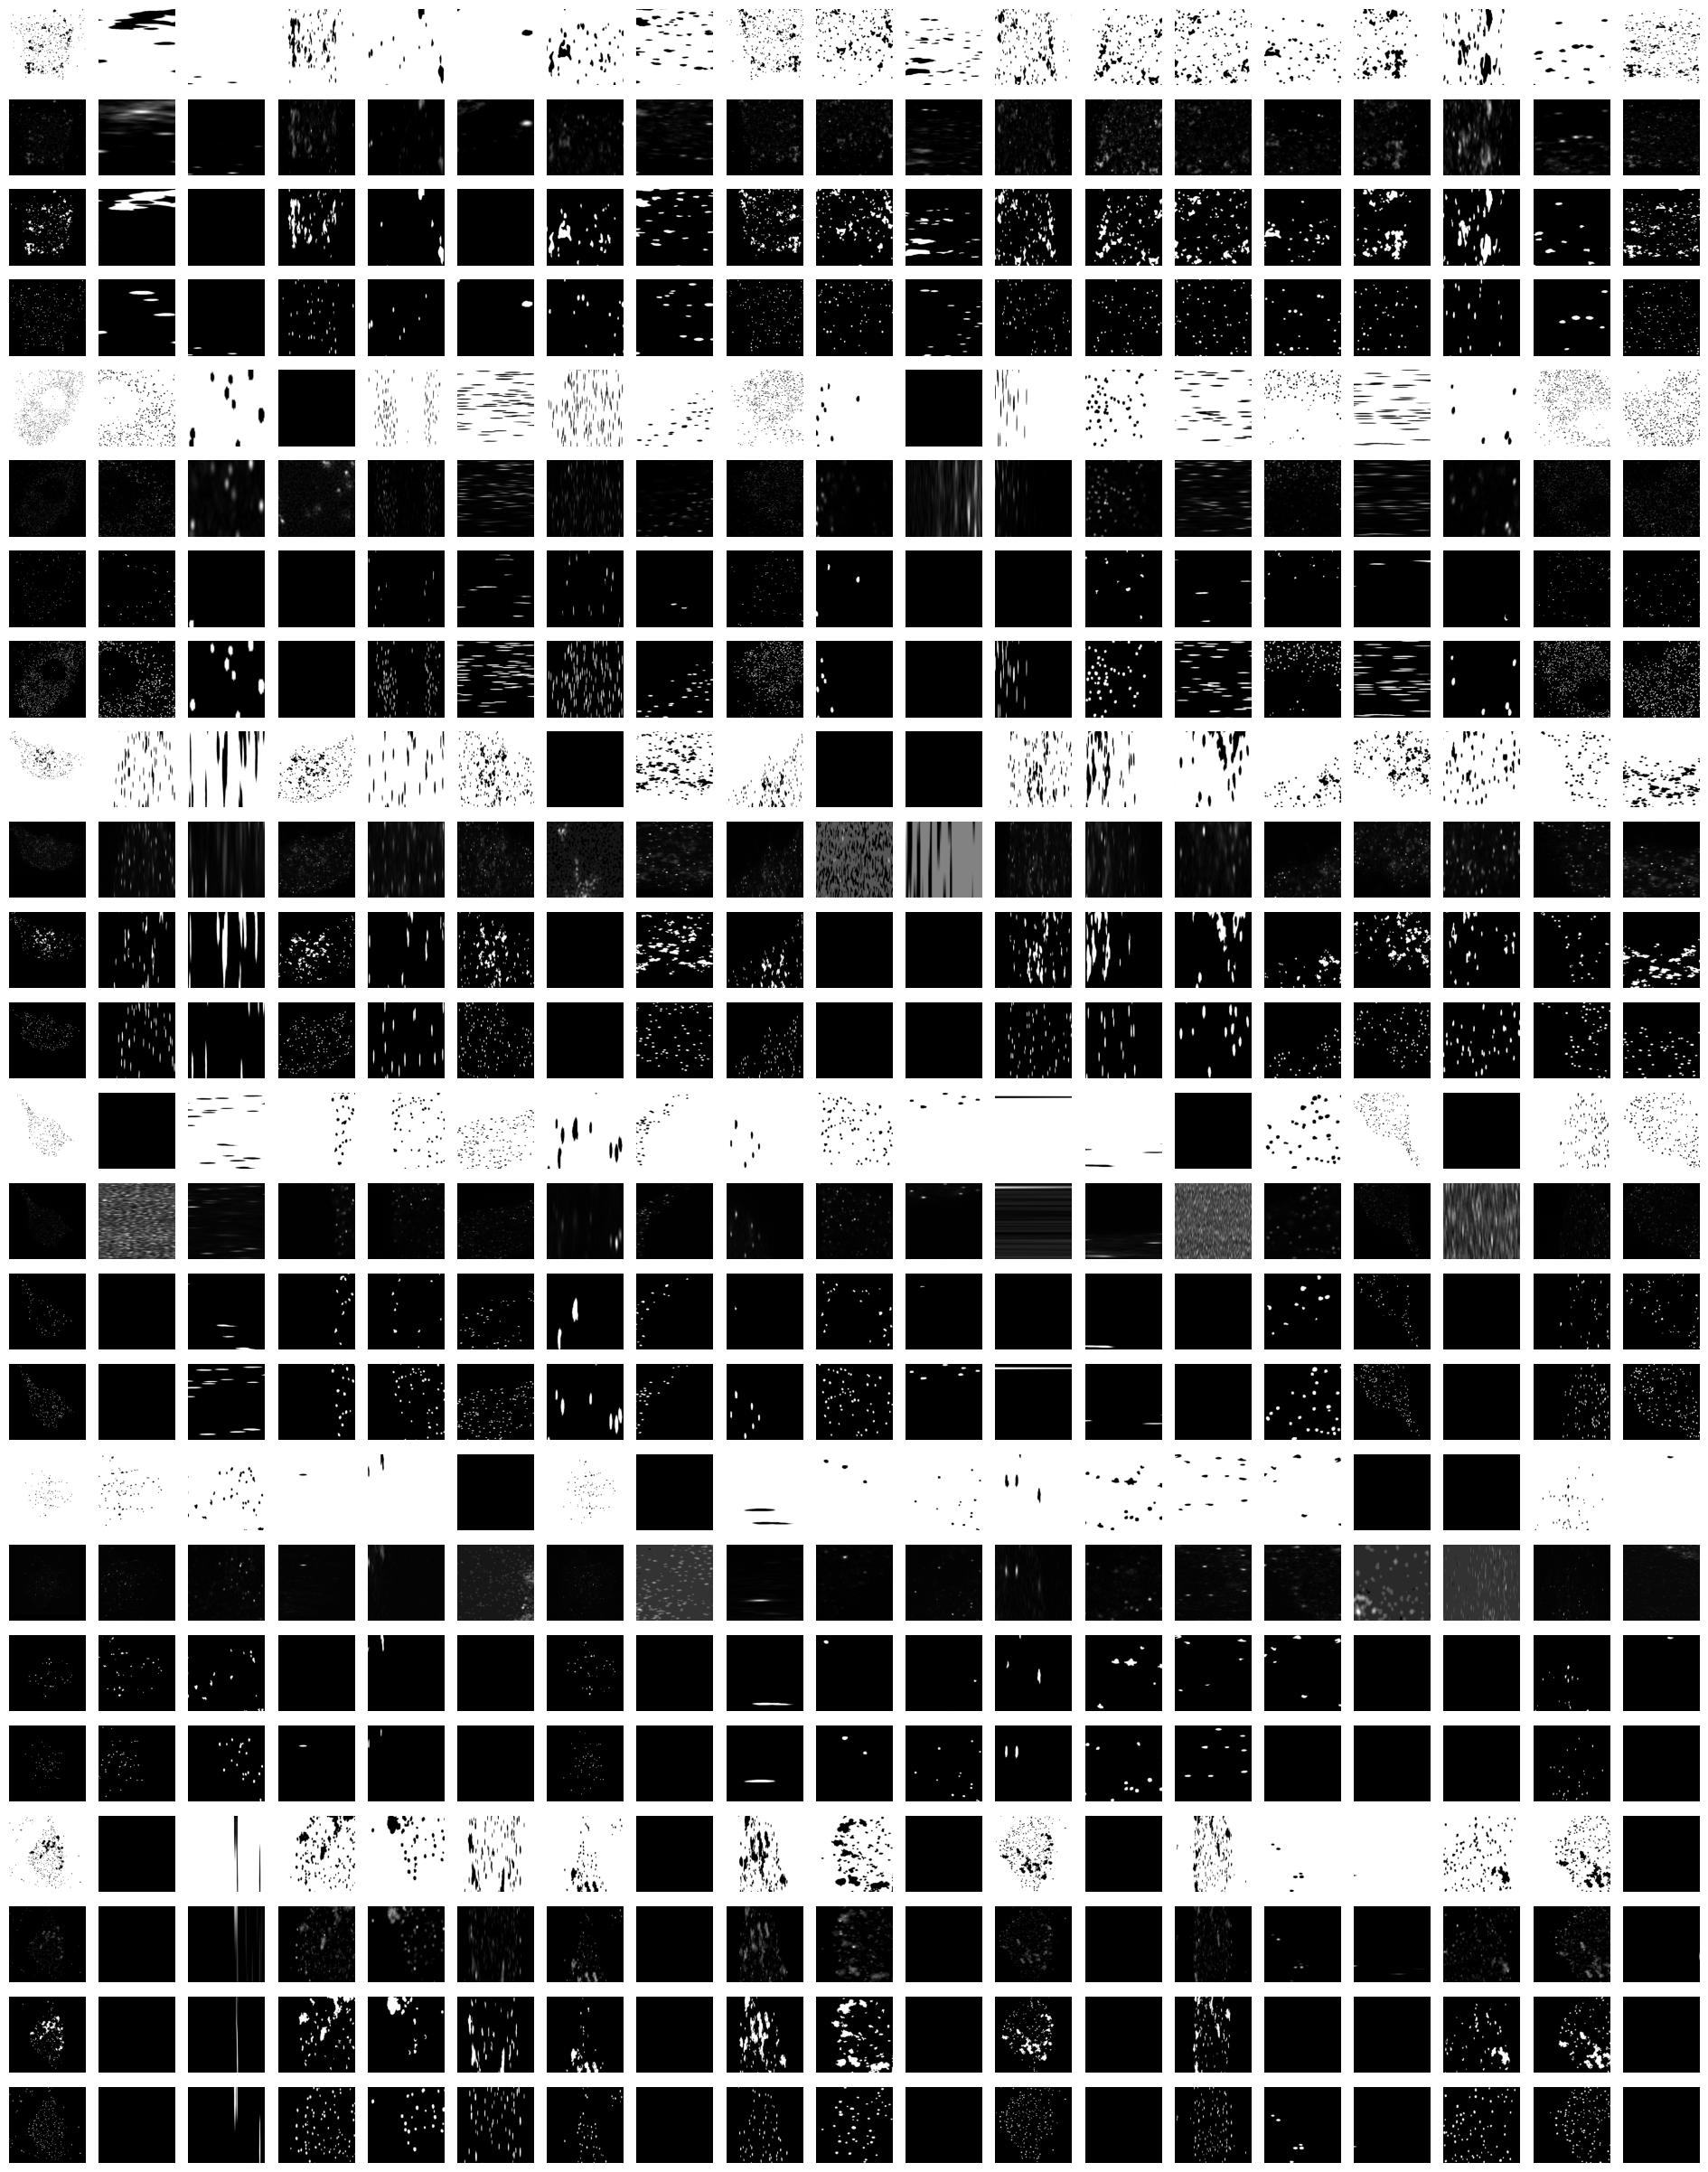

In [7]:
rows = len(crop_list)
cols = NUM_CROPS + 1
plt.figure(figsize=(cols, rows))
for num, x in enumerate(crop_list):
    plt.subplot(rows,cols,num+1)
    plt.axis('off')
    plt.imshow(x, cmap = "gray")

plt.tight_layout()

In [8]:
direc_name = crop_dir
file_name_save = os.path.join(output_dir, 'data.npz')
training_direcs = [i for i in os.listdir(direc_name)]
channel_names = ["image"]

# maximum number of training cases
max_training_examples = 10000000

nb_direcs = len(training_direcs)
nb_channels = len(channel_names)

# variables for images
imglist = []
for direc in training_direcs:
    imglist += getfiles(direc)

In [9]:
# Initialize arrays for the training images and the classes
channels = np.zeros((nb_direcs, image_size_x, image_size_y, nb_channels), dtype='float32')
class_mask = np.zeros((nb_direcs, image_size_x, image_size_y, nb_classes), dtype='float32')

In [11]:
import warnings
warnings.filterwarnings('ignore')

direc_counter = 0

conv_dir = os.path.join(crop_dir_base, 'conv')
if not os.path.isdir(conv_dir):
    os.mkdir(conv_dir)

for ddx, direc in enumerate(training_direcs):
    imglist = os.listdir(os.path.join(direc_name, direc))
    imgdir = os.path.join(conv_dir, direc)
    if not os.path.isdir(imgdir):
        os.mkdir(imgdir)
    channel_counter = 0

    # Load channels
    for idx, channel in enumerate(channel_names):
        for jdx, img in enumerate(imglist):
            if fnmatch.fnmatch(img, r'*' + channel + r'*'):
                print(f"Loading Image {ddx + 1}/{len(training_direcs)}")
                
                channel_img = get_image(os.path.join(direc_name, direc, img))
                
                channel_img = process_image_onlyLocalAverageSubtraction(channel_img, 2*window_size_x + 1, 2*window_size_y + 1)

                savepath = os.path.join(imgdir, f"channel_img.tif")
                imsave(savepath, channel_img)
                
                channels[direc_counter,:,:,channel_counter] = channel_img
                channel_counter += 1

    # Load class mask
    for j in range(nb_classes):
        class_name = "feature_" + str(j) + r".*"
        for kdx, img in enumerate(imglist):
            if fnmatch.fnmatch(img, class_name):
                class_file = os.path.join(direc_name, direc, img)
                class_img = get_image(class_file)

                if np.sum(class_img) > 0:
                    class_img /= np.amax(class_img)

                savepath = os.path.join(imgdir, f"feature_{j}.tif")
                imsave(savepath, class_img)

                class_mask[direc_counter,:,:,j] = class_img
   
    direc_counter += 1

Loading Image 1/114
Loading Image 2/114
Loading Image 3/114
Loading Image 4/114
Loading Image 5/114
Loading Image 6/114
Loading Image 7/114
Loading Image 8/114
Loading Image 9/114
Loading Image 10/114
Loading Image 11/114
Loading Image 12/114
Loading Image 13/114
Loading Image 14/114
Loading Image 15/114
Loading Image 16/114
Loading Image 17/114
Loading Image 18/114
Loading Image 19/114
Loading Image 20/114
Loading Image 21/114
Loading Image 22/114
Loading Image 23/114
Loading Image 24/114
Loading Image 25/114
Loading Image 26/114
Loading Image 27/114
Loading Image 28/114
Loading Image 29/114
Loading Image 30/114
Loading Image 31/114
Loading Image 32/114
Loading Image 33/114
Loading Image 34/114
Loading Image 35/114
Loading Image 36/114
Loading Image 37/114
Loading Image 38/114
Loading Image 39/114
Loading Image 40/114
Loading Image 41/114
Loading Image 42/114
Loading Image 43/114
Loading Image 44/114
Loading Image 45/114
Loading Image 46/114
Loading Image 47/114
Loading Image 48/114
L

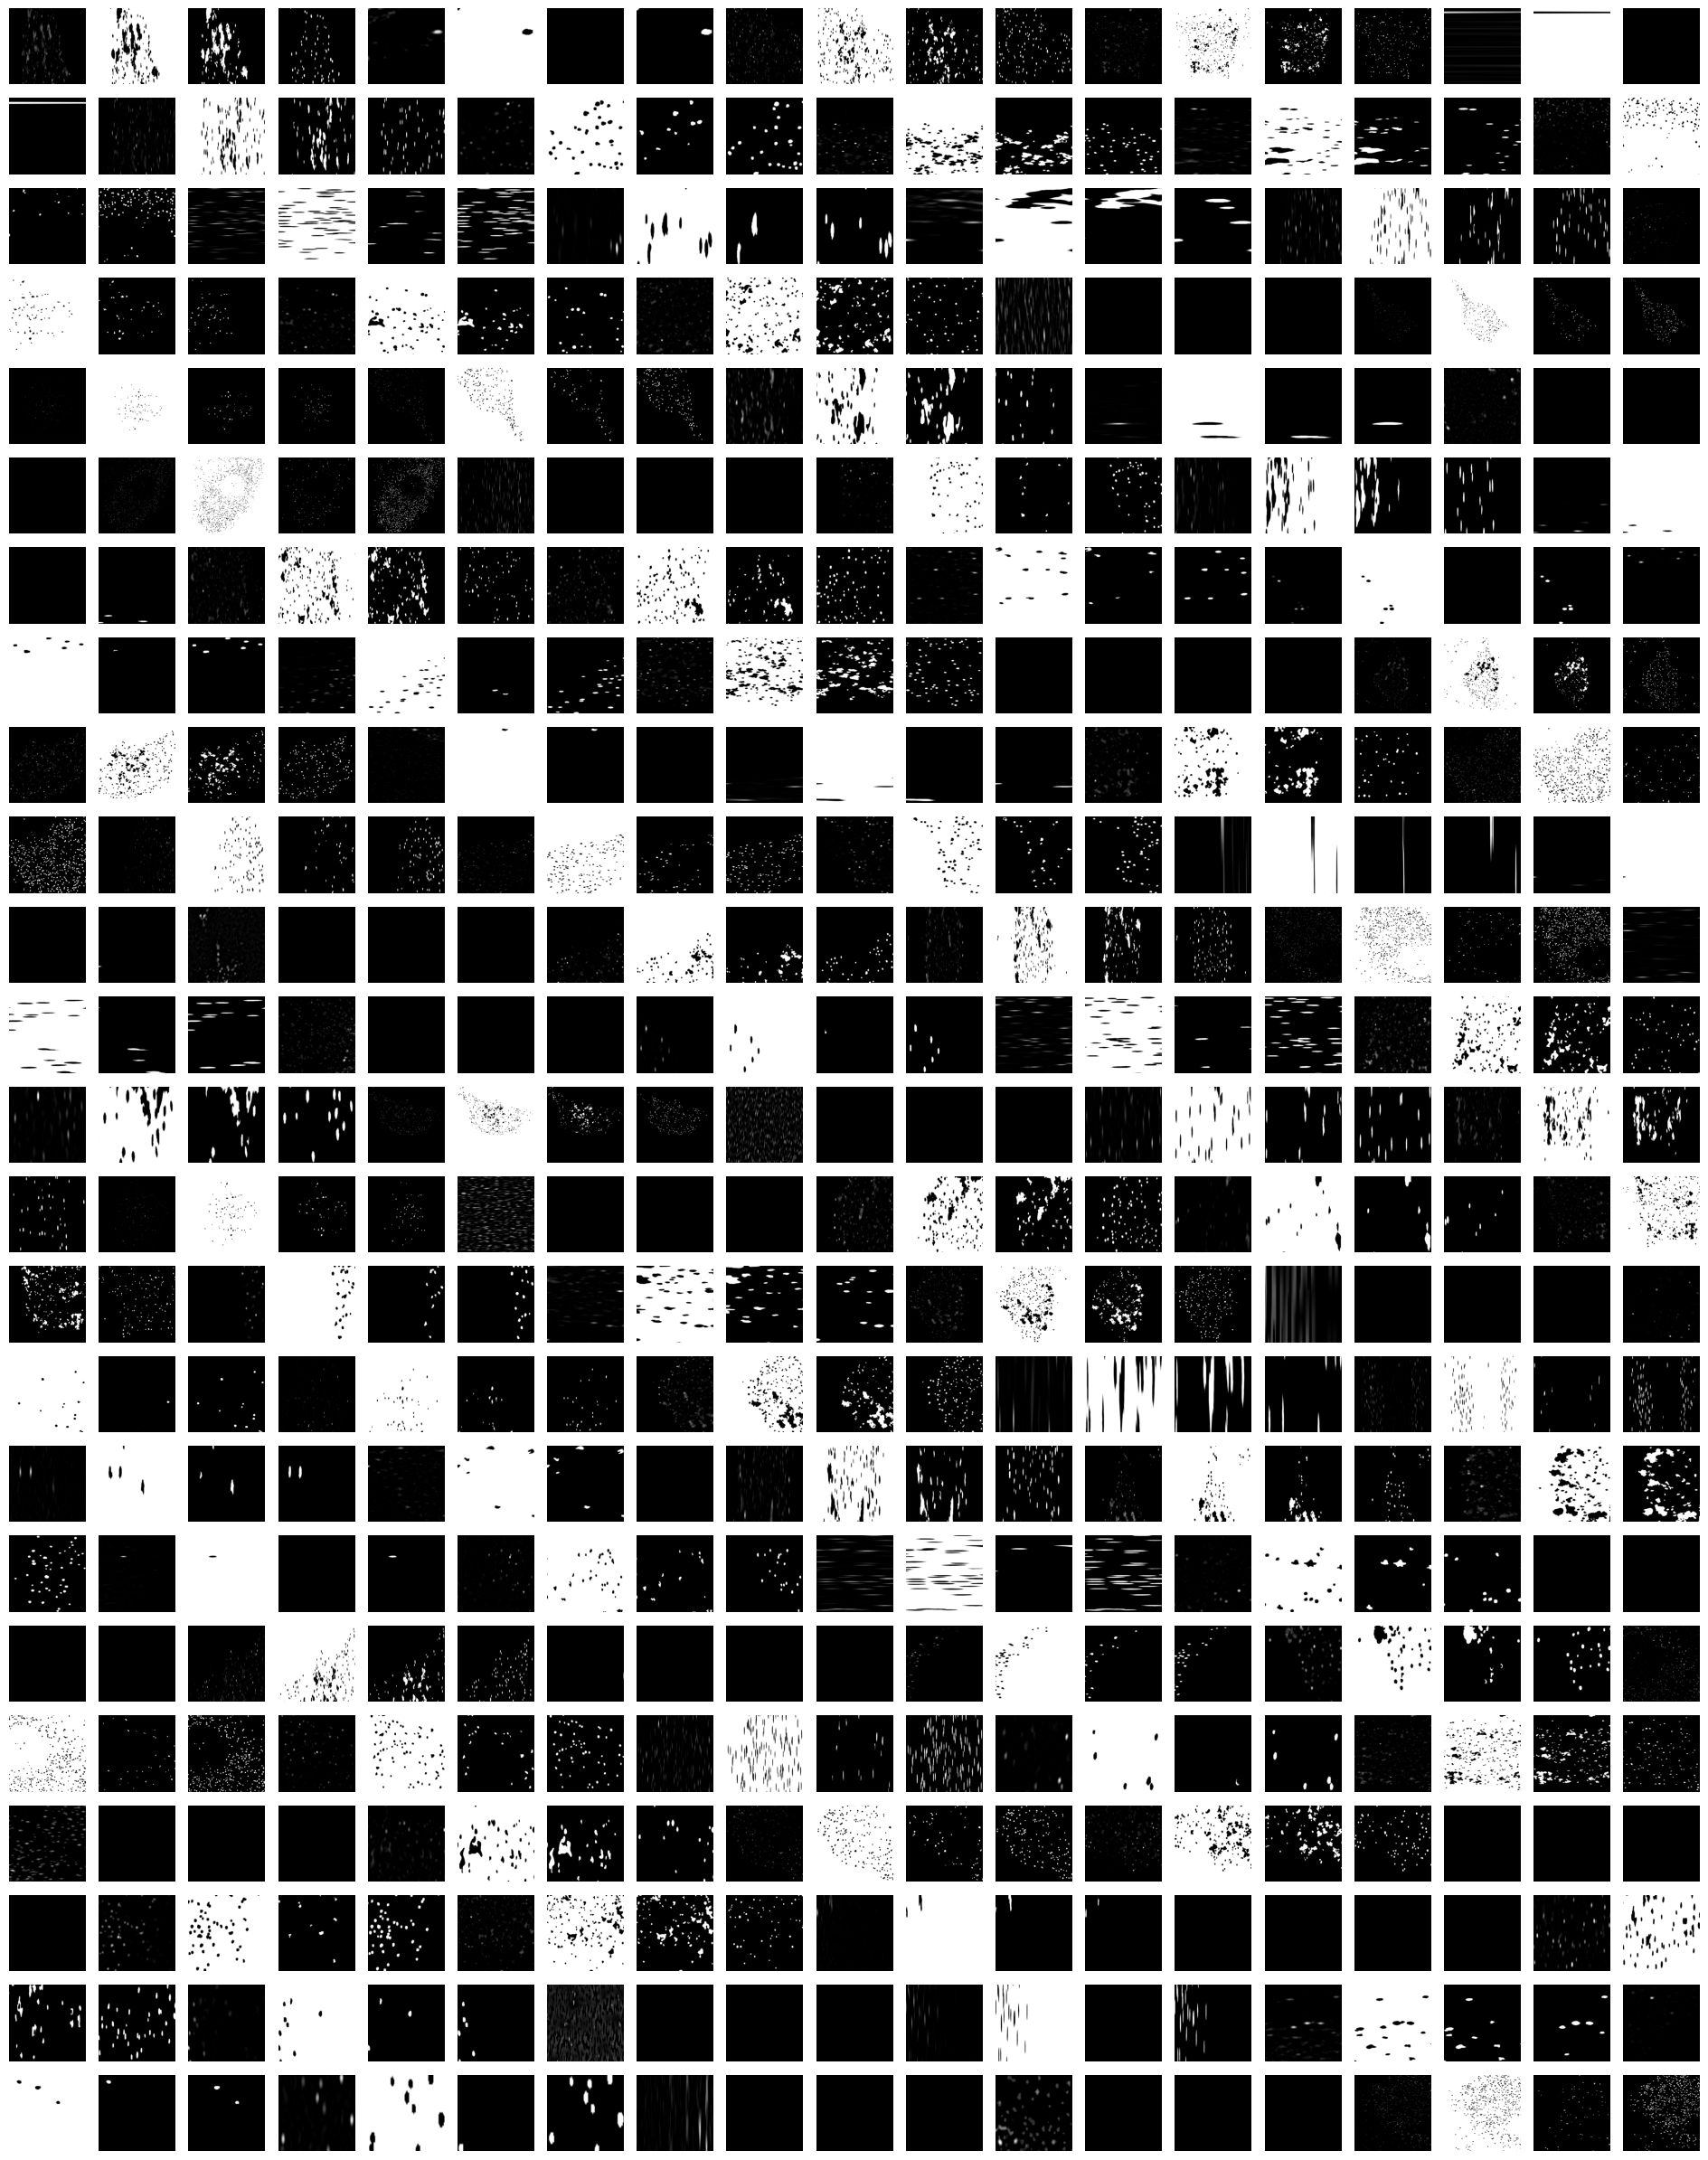

In [12]:
rows = int(len(os.listdir(conv_dir)) / (NUM_CROPS + 1) * 4)
cols = NUM_CROPS + 1
plt.figure(figsize=(cols, rows))
for num, x in enumerate(os.listdir(conv_dir)):
    for fidx, f in enumerate(os.listdir(os.path.join(conv_dir, x))):
        
        plt.subplot(rows,cols,num * 4 + fidx +1)
        plt.axis('off')
        im = imread(os.path.join(conv_dir, x, f))
        plt.imshow(im, cmap = "gray")

plt.tight_layout()

In [13]:
class_mask_trimmed = class_mask[:,window_size_x+1:-window_size_x-1,window_size_y+1:-window_size_y-1,:] 

class_rows = []
class_cols = []
class_batch = []
class_label = []

min_pixel_counter = np.zeros((nb_direcs))
for j in range(class_mask_trimmed.shape[0]):
    min_pixel_counter[j] = np.Inf
    nb_pixels_class = 0
    for k in range(nb_classes):
        nb_pixels_class = np.sum(class_mask_trimmed[j,:,:,k])
        if nb_pixels_class < min_pixel_counter[j]:
            min_pixel_counter[j] = nb_pixels_class
            
for direc in range(channels.shape[0]):
    
    for k in range(nb_classes):
        class_counter = 0
        class_rows_temp, class_cols_temp = np.where(class_mask[direc,:,:,k] == 1)

        if len(class_rows_temp) > 0:

            # Randomly permute index vector
            non_rand_ind = np.arange(len(class_rows_temp))
            rand_ind = np.random.choice(non_rand_ind, size = len(class_rows_temp), replace = False)

            for i in rand_ind:
                if class_counter < min_pixel_counter[direc]:
                    if (class_rows_temp[i] - window_size_x > 0) and (class_rows_temp[i] + window_size_x < image_size_x): 
                        if (class_cols_temp[i] - window_size_y > 0) and (class_cols_temp[i] + window_size_y < image_size_y):
                            class_rows += [class_rows_temp[i]]
                            class_cols += [class_cols_temp[i]]
                            class_batch += [direc]
                            class_label += [k]
                            class_counter += 1

class_rows = np.array(class_rows,dtype = 'int32')
class_cols = np.array(class_cols,dtype = 'int32')
class_batch = np.array(class_batch, dtype = 'int32')
class_label = np.array(class_label, dtype = 'int32')

# Randomly select training points 
if len(class_rows) > max_training_examples:
    non_rand_ind = np.arange(len(class_rows))
    rand_ind = np.random.choice(non_rand_ind, size = max_training_examples, replace = False)

    class_rows = class_rows[rand_ind]
    class_cols = class_cols[rand_ind]
    class_batch = class_batch[rand_ind]
    class_label = class_label[rand_ind]

# Randomize
non_rand_ind = np.arange(len(class_rows))
rand_ind = np.random.choice(non_rand_ind, size = len(class_rows), replace = False)

class_rows = class_rows[rand_ind]
class_cols = class_cols[rand_ind]
class_batch = class_batch[rand_ind]
class_label = class_label[rand_ind]

np.savez(file_name_save, channels = channels, y = class_label, 
         batch = class_batch, pixels_x = class_rows, pixels_y = class_cols, 
         win_x = window_size_x, win_y = window_size_y)